In [1]:
import os
os.system('cp -r ../input/pretrained-models-cadene/pretrained_models_pytroch/ /kaggle/working/')
os.chdir('/kaggle/working/pretrained_models_pytroch/pretrained-models.pytorch-master')
!python setup.py install
# !pip install pretrainedmodels

    100% |████████████████████████████████| 61kB 4.3MB/s ta 0:00:011
  Stored in directory: /tmp/.cache/pip/wheels/69/df/63/62583c096289713f22db605aa2334de5b591d59861a02c2ecd
Successfully built pretrainedmodels
You are using pip version 19.0.3, however version 19.1.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [2]:
import fastai
from fastai.vision import *
fastai.__version__

'1.0.51'

In [3]:
from fastai.vision.models.cadene_models import *

import pretrainedmodels

In [4]:
BATCH  = 32
SIZE   = 320

In [5]:
def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
seed_everything()

In [6]:
def get_model(model_name:str, pretrained:bool, seq:bool=False, pname:str='imagenet', **kwargs):
    pretrained = pname if pretrained else None
    model = getattr(pretrainedmodels, model_name)(pretrained=pretrained, **kwargs)
    return nn.Sequential(*model.children()) if seq else model

def se_resnext101_32x4d(pretrained:bool=False): return get_model('se_resnext101_32x4d', pretrained)

In [7]:
os.chdir('/kaggle/working')
os.listdir('.')

['__notebook_source__.ipynb', '.ipynb_checkpoints']

# Initial setup

In [8]:
path = Path('../input/imet-2019-fgvc6/') # iMet data path

In [9]:
os.listdir('../input')

['resnet152',
 'pytorch-model-zoo',
 'resnet18',
 'seresnext101epochs7',
 'seresnext101epochs19',
 'densenet201',
 'seresnext101epochs29',
 'seresnext50epochs17',
 'seresnext101epochs14',
 'seresnext101epochs34',
 'seresnext50epochs23',
 'seresnext101epochs24',
 'resnet50',
 'se-resnext-pytorch-pretrained',
 'densenet121',
 'pretrained-models-cadene',
 'seresnext50epochs29',
 'resnet101',
 'imetfolds',
 'imet-2019-fgvc6']

In [10]:
# Making pretrained weights work without needing to find the default filename
from torch.utils import model_zoo
Path('models').mkdir(exist_ok=True)
!cp '../input/seresnext101epochs15/stage-1.pth' 'models/se_resnext101_32x4d-3b2fe3d8.pth'
def load_url(*args, **kwargs):
    model_dir = Path('models')
    filename  = 'se_resnext101_32x4d-3b2fe3d8.pth'
    if not (model_dir/filename).is_file(): raise FileNotFoundError
    return torch.load(model_dir/filename)
model_zoo.load_url = load_url

In [11]:
# Load train dataframe
train_df = pd.read_csv(path/'train.csv')
train_df.head()

,id,attribute_ids
0,1000483014d91860,147 616 813
1,1000fe2e667721fe,51 616 734 813
2,1001614cb89646ee,776
3,10041eb49b297c08,51 671 698 813 1092
4,100501c227f8beea,13 404 492 903 1093


In [12]:
# Load labels dataframe
labels_df = pd.read_csv(path/'labels.csv')
labels_df.head()

,attribute_id,attribute_name
0,0,culture::abruzzi
1,1,culture::achaemenid
2,2,culture::aegean
3,3,culture::afghan
4,4,culture::after british


In [13]:
# Load sample submission
test_df = pd.read_csv(path/'sample_submission.csv')
test_df.head()

,id,attribute_ids
0,10023b2cc4ed5f68,0 1 2
1,100fbe75ed8fd887,0 1 2
2,101b627524a04f19,0 1 2
3,10234480c41284c6,0 1 2
4,1023b0e2636dcea8,0 1 2


In [14]:
folds = pd.read_csv('../input/imetfolds/folds.csv')
folds.head()

,id,attribute_ids,fold
0,1000483014d91860,147 616 813,37
1,1000fe2e667721fe,51 616 734 813,8
2,1001614cb89646ee,776,39
3,10041eb49b297c08,51 671 698 813 1092,12
4,100501c227f8beea,13 404 492 903 1093,26


# Create data object using datablock API

In [15]:
tfms = get_transforms(do_flip=True, flip_vert=False, max_rotate=0.10, max_zoom=1.5, max_warp=0.2, max_lighting=0.2,
                      xtra_tfms=[(symmetric_warp(magnitude=(-0,0), p=0.5)), rand_crop(p=0.75),])

In [16]:
train, test = [ImageList.from_df(df, path=path, cols='id', folder=folder, suffix='.png') 
               for df, folder in zip([train_df, test_df], ['train', 'test'])]
data = (train.split_by_rand_pct(0.1, seed=42)
        .label_from_df(cols='attribute_ids', label_delim=' ')
        .add_test(test)
        .transform(tfms, size=SIZE, resize_method=ResizeMethod.PAD, padding_mode='border',)
        .databunch(path=Path('.'), bs=BATCH).normalize(imagenet_stats))

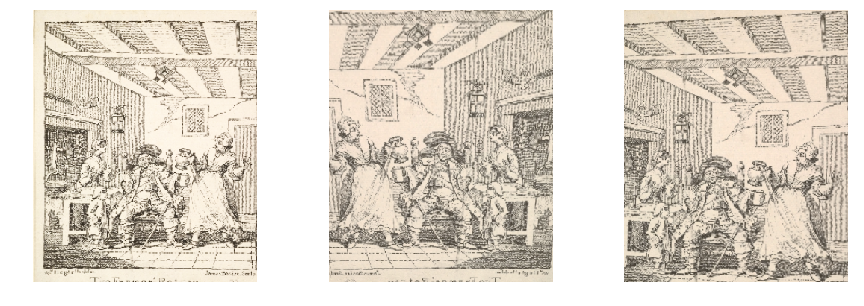

In [17]:
def get_img():
    return open_image(path/'train/868060948f7b1b6c.png')

def apply_trans_forms(rows=1, cols=3, width=15, height=5, **kwargs):
    img = get_img()
    [img.apply_tfms(tfms[0], **kwargs).show(ax=ax) for i,ax in enumerate(plt.subplots(rows,cols,
                                                                                          figsize=(width,height))[1].flatten())]
apply_trans_forms()

# Create learner with resnet50 and FocalLoss
For problems with high class imbalance Focal Loss is usually a better choice than the usual Cross Entropy Loss.

In [18]:
# Source: https://www.kaggle.com/c/human-protein-atlas-image-classification/discussion/78109
class FocalLoss(nn.Module):
    def __init__(self, gamma=2):
        super().__init__()
        self.gamma = gamma

    def forward(self, logit, target):
        target = target.float()
        max_val = (-logit).clamp(min=0)
        loss = logit - logit * target + max_val + \
               ((-max_val).exp() + (-logit - max_val).exp()).log()

        invprobs = F.logsigmoid(-logit * (target * 2.0 - 1.0))
        loss = (invprobs * self.gamma).exp() * loss
        if len(loss.size())==2:
            loss = loss.sum(dim=1)
        return loss.mean()

In [19]:
# pretrained version
# learn = cnn_learner(data, base_arch=se_resnext101_32x4d, loss_func=FocalLoss(), metrics=fbeta)

Downloading: "http://data.lip6.fr/cadene/pretrainedmodels/se_resnext101_32x4d-3b2fe3d8.pth" to /tmp/.torch/models/se_resnext101_32x4d-3b2fe3d8.pth
196466866it [09:12, 355450.14it/s]


In [20]:
load weights & finetune
learn = cnn_learner(data, base_arch=se_resnext101_32x4d, loss_func=FocalLoss(), metrics=fbeta, pretrained=False)
learn.load('se_resnext101_32x4d-3b2fe3d8')

# Get predictions

In [ ]:
def find_best_fixed_threshold(preds, targs, do_plot=True):
    score = []
    thrs = np.arange(0, 0.5, 0.01)
    for thr in progress_bar(thrs):
        score.append(fbeta(valid_preds[0],valid_preds[1], thresh=thr))
    score = np.array(score)
    pm = score.argmax()
    best_thr, best_score = thrs[pm], score[pm].item()
    print(f'thr={best_thr:.3f}', f'F2={best_score:.3f}')
    if do_plot:
        plt.plot(thrs, score)
        plt.vlines(x=best_thr, ymin=score.min(), ymax=score.max())
        plt.text(best_thr+0.03, best_score-0.01, f'$F_{2}=${best_score:.3f}', fontsize=14);
        plt.show()
    return best_thr

i2c = np.array([[i, c] for c, i in learn.data.train_ds.y.c2i.items()]).astype(int) # indices to class number correspondence

def join_preds(preds, thr):
    return [' '.join(i2c[np.where(t==1)[0],1].astype(str)) for t in (preds[0].sigmoid()>thr).long()]

In [ ]:
# Validation predictions
valid_preds = learn.TTA(ds_type=DatasetType.Valid)
best_thr = find_best_fixed_threshold(*valid_preds)
print(best_thr)

In [ ]:
preds_t = np.stack(valid_preds)
np.save('val_preds.npy', preds_t)
print(preds_t.shape)

In [ ]:
# Test predictions
test_preds = learn.TTA(ds_type=DatasetType.Test)

preds_t = test_preds[0].numpy()
np.save('test_preds.npy', preds_t)
print(preds_t.shape)

test_df.attribute_ids = join_preds(test_preds, best_thr)
test_df.head()

In [ ]:
test_df.to_csv('submission.csv', index=False)

In [ ]:
!rm -rf /kaggle/working/pretrained_models_pytroch